# __Distance qualitative analysis__

### __Calculators definitions__

In [1]:
# ANI


# import the calculators
from torch import device
from torchani.models import ANI1x, ANI2x, ANI1ccx

ani1x_calc = ANI1x().ase()
ani1ccx_calc = ANI1ccx().ase()
ani2x_calc = ANI2x().ase()

# device type can defined via torch and parsed to the model via .to() method
#device_ = device('cpu')
#model_ = ANI1x(periodic_table_index=True).to(device_).double().ase()


# MACE
from mace.calculators import mace_mp, mace_off

macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float32", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float32'
    )

# ORB

from orb_models.forcefield.pretrained import orb_v2, orb_d3_v2
from orb_models.forcefield.calculator import ORBCalculator

orbff_v2 = orb_v2(device='cpu')
orb_calc_v2 = ORBCalculator(orbff_v2, device='cpu')

orbff_d3_v2 = orb_d3_v2(device='cpu')
orb_calc_d3_v2 = ORBCalculator(orbff_d3_v2, device='cpu')


CALC_NAME = 'ALL'

/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indice

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

In [2]:
# define the calculators
calculator_list = [ani1x_calc, ani1ccx_calc, ani2x_calc, macemp, maceoff, orb_calc_v2, orb_calc_d3_v2]
calculator_names = ['ANI-1x', 'ANI-1ccx', 'ANI-2x', 'MACE-MP', 'MACE-OFF', 'ORB-V2', 'ORB-D3-V2']
calculator_colors = ['darkviolet', 'crimson', 'deeppink', 'darkgreen', 'mediumseagreen', 'royalblue', 'darkblue']

color_dict = {
    'ANI-1x': 'darkviolet', 
    'ANI-1ccx': 'crimson', 
    'ANI-2x': 'deeppink', 
    'MACE-MP': 'darkgreen', 
    'MACE-OFF':  'mediumseagreen', 
    'ORB-V2': 'royalblue', 
    'ORB-D3-V2': 'darkblue',
}

## __General imports__

In [3]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase import Atoms
from ase.visualize import view
from ase.build import molecule
from ase.io import write, read
from ase.io import Trajectory, trajectory
from ase import build
from ase.data.pubchem import pubchem_atoms_search

In [4]:
def evaluate_diatomics(atom_str, calculator_list, search_space=None , resolution=None, verbose=True):
    '''
    Definition
    ----------
    Evaluates the PES of simple (homoatomic) diatomic molecules A_2. 

    '''

    if resolution is None:
        resolution = 100

    if search_space is None:
        search_space = [0.3, 6.5]
    dist_list = np.linspace(search_space[0], search_space[1], resolution)

    print(f'computing {atom_str}2 PES\tscan range {search_space} Å')

    # save energies
    energies = []
    succ_calcs = []

    # evaluate each calculator
    k = 0
    for calc_ in calculator_list: 
        k += 1

        try:
            calc_energy_list = []
            
            for d in dist_list:

                # define the configuration
                atoms = Atoms(atom_str + '2', [[0, 0, 0], [0, 0, d]])
                atoms.calc = calc_
                E_pot = atoms.get_potential_energy()
                calc_energy_list.append(E_pot)
            
            atom = Atoms(atom_str)
            atom.calc = calc_
            atom_dissociated = 2 * atom.get_potential_energy()
            corrected_energies = np.array(calc_energy_list) - atom_dissociated

            energies.append(corrected_energies)
            succ_calcs.append(calculator_names[k-1])

        except: 
            print(f'calculator {calculator_names[k-1]} failed')

    return dist_list, energies, succ_calcs


def plot_diatomics(atom_str_list, calculator_names, color_dict, global_energies, global_distances, workdir='./', ylims=None, name='', switch=False):
    '''
    Plot the different PES obtained via `evaluate_diatomics`. 
    '''

    nrows = int(len(atom_str_list)/2)
    ncols = 2
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(int(4*ncols), int(4*nrows)))
    
    if nrows == 1:
        ax_list = [ax for ax in axes]

    elif nrows == 2:
        ax_list = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]
    else: 
        raise ValueError('num of rows exploded')

    for i in range(len(atom_str_list)):
        ax_list[i].tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax_list[i].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")


        for k in range(len(calculator_names[i])):
            ax_list[i].plot(global_distances[i], global_energies[i][k][:], label=r'$\textnormal{' + calculator_names[i][k] + r'}$', color=color_dict[calculator_names[i][k]], alpha=0.9)

            if ylims is not None:
                ax_list[i].set_ylim(ylims[i][0], ylims[i][1])

        ax_list[i].set(xlabel=r'$\textnormal{' + f'{atom_str_list[i]}--{atom_str_list[i]}' + r' bond distance}\;\textnormal{(Å)}$')
        
        if switch:
            if i == len(atom_str_list)-1:
                ax_list[i].legend(loc='center right', bbox_to_anchor=(1.45, 0.5), prop={'size': 9})

            if i%ncols == 0:
                ax_list[i].set(ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$')

        else: 
            ax_list[i].legend(loc='best', prop={'size': 9})
            ax_list[i].set(ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$')

    plt.tight_layout()
    plt.savefig(os.path.join(workdir, f'PES_diatomics_{name}.pdf'))
    plt.show(fig)



### __H2 diatomic potential__

computing C2 PES	scan range [0.8, 6.5] Å
computing O2 PES	scan range [0.9, 6.5] Å
computing Si2 PES	scan range [1.5, 6.5] Å
calculator ANI-1x failed
calculator ANI-1ccx failed
calculator ANI-2x failed
calculator MACE-OFF failed
computing Cl2 PES	scan range [1.5, 6.5] Å
calculator ANI-1x failed
calculator ANI-1ccx failed


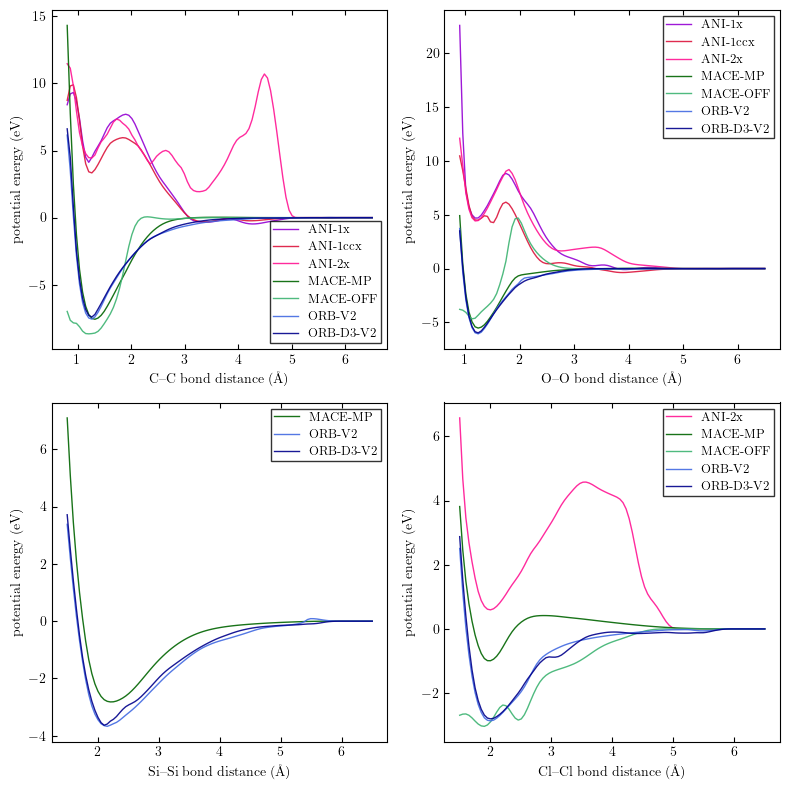

In [5]:
# define the diatomics and the PES scan range
atom_str_list = ['C', 'O', 'Si', 'Cl']
search_list = [[0.8, 6.5], [0.9, 6.5], [1.5, 6.5], [1.5, 6.5]]

# create path to store results
workdir = 'PES_distances'
if not os.path.isdir(workdir):
    os.makedirs(workdir)

# dimension: [atom_len, calc_len, resolution]
global_energies = []

# dimension: [atom_len, resolution]
global_distances = []

global_succ_calcs = []

# compute all the PES
for i in range(len(atom_str_list)):
    dist_list, energies, succ_calcs = evaluate_diatomics(atom_str_list[i], calculator_list, search_space=search_list[i], resolution=100)
    global_energies.append(energies)
    global_distances.append(dist_list)
    global_succ_calcs.append(succ_calcs)

plot_diatomics(atom_str_list, global_succ_calcs, color_dict=color_dict, global_energies=global_energies, global_distances=global_distances, workdir=workdir, switch=False, name='COSiCl')

computing H2 PES	scan range [0.3, 6.5] Å
computing N2 PES	scan range [0.8, 6.5] Å


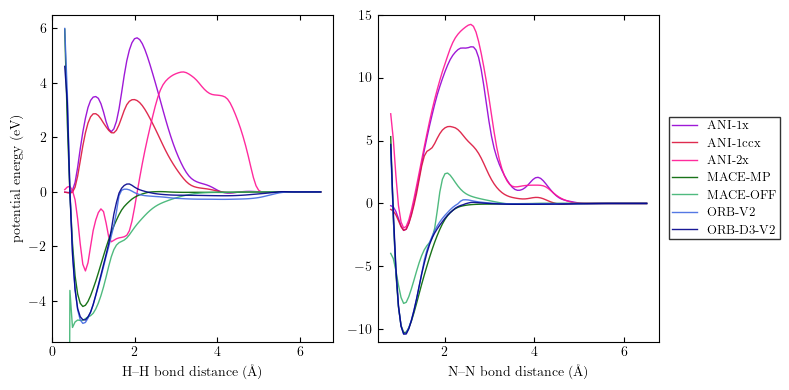

In [8]:
# define the diatomics and the PES scan range
atom_str_list = ['H', 'N']
search_list = [[0.3, 6.5], [0.8, 6.5]]
ylims = [[-5.5, 6.5], [-11, 15]]
# create path to store results
workdir = 'PES_distances'
if not os.path.isdir(workdir):
    os.makedirs(workdir)

# dimension: [atom_len, calc_len, resolution]
global_energies = []

# dimension: [atom_len, resolution]
global_distances = []

global_succ_calcs = []

# compute all the PES
for i in range(len(atom_str_list)):
    dist_list, energies, succ_calcs = evaluate_diatomics(atom_str_list[i], calculator_list, search_space=search_list[i], resolution=100)
    global_energies.append(energies)
    global_distances.append(dist_list)
    global_succ_calcs.append(succ_calcs)

plot_diatomics(atom_str_list, global_succ_calcs, color_dict=color_dict, global_energies=global_energies, global_distances=global_distances, workdir=workdir, ylims=ylims, name='HC', switch=True)

## __Bond breaking__
This section aims to explore the same concept as with diatomics, but with general fragments. Given a bond, it is elongated until destruction. 


Obs. La referència de l'energia, estrictament parlant, hauria de ser l'energia dels fragments. Això no es té en compte. Es pot fixar la referència d'energia en la conformació més estable, igual que en els dihedres o els angles. 

In [50]:
def evaluate_bond(molecule, bond_ids, mask,  calculator_list, search_space=None , resolution=None, mol_name='', visualize=True):
    '''
    Definition
    ----------
    Evaluates the PES of the breaking of a bond.
    bond_ids contain the index of the atoms that form the bond. 
    '''


    # create the working directory
    work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
    if not os.path.isdir(work_dir):
        os.makedirs(work_dir)

    # define scan space and resolution
    if resolution is None:
        resolution = 100
    if search_space is None:
        search_space = [1.0, 6.0]
    dist_list = np.linspace(search_space[0], search_space[1], resolution)
    
    # create a trajectory file for the scan (one calculator only)
    if len(calculator_list) == 1:
        traj_path = os.path.join(work_dir, 'bond_scan.traj')
        traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')


    # compute the distances
    print(f'computing {molecule[bond_ids[0]].symbol}{molecule[bond_ids[0]].index}-{molecule[bond_ids[1]].symbol}{molecule[bond_ids[1]].index} PES\nscan range {search_space} Å')
    print(f'evaluating {len(dist_list)} distances')
    print(f'distances:\n{dist_list}\n')

    # save energies
    energies = []

    # evaluate each calculator
    for calc_ in calculator_list: 

        calc_energy_list = []

        for d in dist_list:

            # define the configuration
            molecule.set_distance(bond_ids[0], bond_ids[1], d, mask=mask, fix=0)
            molecule.calc = calc_
            potential_e = molecule.get_potential_energy()
            calc_energy_list.append(potential_e)
        
            if len(calculator_list) == 1:
                traj.write(molecule)

        # compute reference
        # TODO

        energies.append(calc_energy_list)

        if len(calculator_list) == 1:
            traj.close()

    if visualize:
        if len(calculator_list) == 1:
            traj = trajectory.TrajectoryReader(os.path.join('./', mol_name, 'bond_scan.traj'))
            view(traj, viewer='ase')

    return dist_list, energies



def plot_bond(distance_list, energy_list, calculator_names, calculator_colors, mol_name='', calc_name='', bond_name='',plot_markers=False):
    '''
    Plot a bond scan. 
    '''

    work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)

    if plot_markers:
        _color_list = ['black', 'red', 'orange', 'blue']
        _marker_list = ['^', 'd', 'v', 'o']

    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6,5)) 
    axes.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    axes.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(calculator_names)):
        
        # gather the minimum energy structure
        idx = np.argmin(energy_list[k][:])
        min_energy = energy_list[k][idx]
        min_dih = distance_list[idx]

        # TODO convert energy from eV/particle to kcal/mol: 1 eV/molecule = 23.0605 kcal/mol

        axes.plot(distance_list, (np.array(energy_list[k][:])-min_energy), label=r'$\textnormal{' + calculator_names[k] + r'}$', color=calculator_colors[k], alpha=0.9)
        if plot_markers:
            axes.scatter(min_dih, min_energy-min_energy, color=_color_list[k], marker=_marker_list[k], label=r'$\textnormal{energy ref @ ' + f'{min_dih:.3f}' + r' Å}$')

    axes.set(xlabel=r'$\textnormal{' + f'{mol_name} {bond_name}' + r' bond distance}\;\textnormal{(Å)}$', ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$')
    axes.legend(loc='best', title=f'{mol_name}', title_fontsize='large')

    plt.tight_layout()
    plt.savefig(os.path.join(work_dir, f'{mol_name}_{bond_name}_bond_{calc_name}'+'_PES.png'), dpi=300)
    plt.show(fig)

### __Examples__

computing C0-C1 PES
scan range [1.0, 6.0] Å
evaluating 80 distances
distances:
[1.         1.06329114 1.12658228 1.18987342 1.25316456 1.3164557
 1.37974684 1.44303797 1.50632911 1.56962025 1.63291139 1.69620253
 1.75949367 1.82278481 1.88607595 1.94936709 2.01265823 2.07594937
 2.13924051 2.20253165 2.26582278 2.32911392 2.39240506 2.4556962
 2.51898734 2.58227848 2.64556962 2.70886076 2.7721519  2.83544304
 2.89873418 2.96202532 3.02531646 3.08860759 3.15189873 3.21518987
 3.27848101 3.34177215 3.40506329 3.46835443 3.53164557 3.59493671
 3.65822785 3.72151899 3.78481013 3.84810127 3.91139241 3.97468354
 4.03797468 4.10126582 4.16455696 4.2278481  4.29113924 4.35443038
 4.41772152 4.48101266 4.5443038  4.60759494 4.67088608 4.73417722
 4.79746835 4.86075949 4.92405063 4.98734177 5.05063291 5.11392405
 5.17721519 5.24050633 5.30379747 5.36708861 5.43037975 5.49367089
 5.55696203 5.62025316 5.6835443  5.74683544 5.81012658 5.87341772
 5.93670886 6.        ]



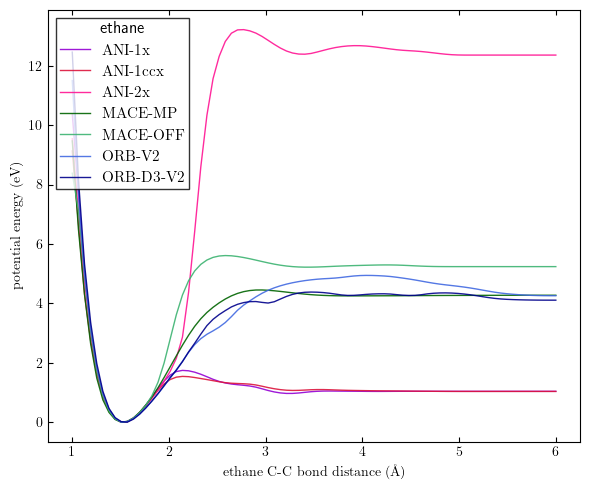

In [51]:
# define the molecule
mol_name = 'ethane'
molecule = build.molecule('C2H6')

# parameters

bond_name = 'C-C'
bond_ids = [0, 1]
mask = [0, 1, 0, 0, 0, 1, 1, 1]

# perform the scan
distances, energies = evaluate_bond(molecule, bond_ids, mask,  calculator_list, search_space=[1.0, 6.0], resolution=80, mol_name=mol_name, visualize=True)
plot_bond(distances, energies, calculator_names, calculator_colors, mol_name=mol_name, calc_name=CALC_NAME, bond_name=bond_name)

computing C1-O2 PES
scan range [1.0, 6.0] Å
evaluating 80 distances
distances:
[1.         1.06329114 1.12658228 1.18987342 1.25316456 1.3164557
 1.37974684 1.44303797 1.50632911 1.56962025 1.63291139 1.69620253
 1.75949367 1.82278481 1.88607595 1.94936709 2.01265823 2.07594937
 2.13924051 2.20253165 2.26582278 2.32911392 2.39240506 2.4556962
 2.51898734 2.58227848 2.64556962 2.70886076 2.7721519  2.83544304
 2.89873418 2.96202532 3.02531646 3.08860759 3.15189873 3.21518987
 3.27848101 3.34177215 3.40506329 3.46835443 3.53164557 3.59493671
 3.65822785 3.72151899 3.78481013 3.84810127 3.91139241 3.97468354
 4.03797468 4.10126582 4.16455696 4.2278481  4.29113924 4.35443038
 4.41772152 4.48101266 4.5443038  4.60759494 4.67088608 4.73417722
 4.79746835 4.86075949 4.92405063 4.98734177 5.05063291 5.11392405
 5.17721519 5.24050633 5.30379747 5.36708861 5.43037975 5.49367089
 5.55696203 5.62025316 5.6835443  5.74683544 5.81012658 5.87341772
 5.93670886 6.        ]



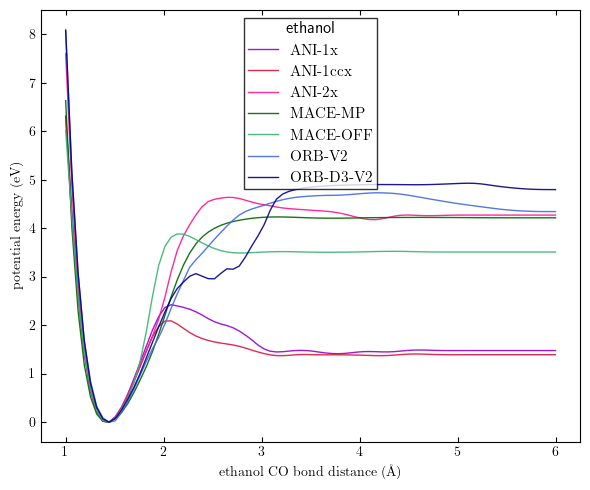

In [52]:
# define the molecule
mol_name = 'ethanol'
molecule = build.molecule('CH3CH2OH')

bond_name = 'CO'
bond_ids = [1, 2]
mask = [0, 0, 1, 1, 0, 0, 0, 0, 0]

# perform the scan
distances, energies = evaluate_bond(molecule, bond_ids, mask,  calculator_list, search_space=[1.0, 6.0], resolution=80, mol_name=mol_name, visualize=True)
plot_bond(distances, energies, calculator_names, calculator_colors, mol_name=mol_name, calc_name=CALC_NAME, bond_name=bond_name)

computing O2-H3 PES
scan range [0.7, 6.0] Å
evaluating 80 distances
distances:
[0.7        0.76708861 0.83417722 0.90126582 0.96835443 1.03544304
 1.10253165 1.16962025 1.23670886 1.30379747 1.37088608 1.43797468
 1.50506329 1.5721519  1.63924051 1.70632911 1.77341772 1.84050633
 1.90759494 1.97468354 2.04177215 2.10886076 2.17594937 2.24303797
 2.31012658 2.37721519 2.4443038  2.51139241 2.57848101 2.64556962
 2.71265823 2.77974684 2.84683544 2.91392405 2.98101266 3.04810127
 3.11518987 3.18227848 3.24936709 3.3164557  3.3835443  3.45063291
 3.51772152 3.58481013 3.65189873 3.71898734 3.78607595 3.85316456
 3.92025316 3.98734177 4.05443038 4.12151899 4.18860759 4.2556962
 4.32278481 4.38987342 4.45696203 4.52405063 4.59113924 4.65822785
 4.72531646 4.79240506 4.85949367 4.92658228 4.99367089 5.06075949
 5.1278481  5.19493671 5.26202532 5.32911392 5.39620253 5.46329114
 5.53037975 5.59746835 5.66455696 5.73164557 5.79873418 5.86582278
 5.93291139 6.        ]



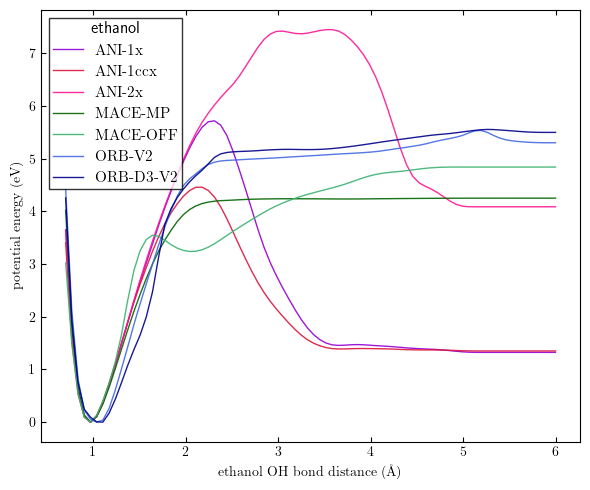

In [53]:
# define the molecule
mol_name = 'ethanol'
molecule = build.molecule('CH3CH2OH')

bond_name = 'OH'
bond_ids = [2, 3]
mask = [0, 0, 0, 1, 0, 0, 0, 0, 0]

# perform the scan
distances, energies = evaluate_bond(molecule, bond_ids, mask,  calculator_list, search_space=[0.7, 6.0], resolution=80, mol_name=mol_name, visualize=True)
plot_bond(distances, energies, calculator_names, calculator_colors, mol_name=mol_name, calc_name=CALC_NAME, bond_name=bond_name)

# __Cylobutadiene Analysis__
Assess the asymmetry knowledge of the models

In [54]:
# define the molecule
mol_name = 'cylobutadiene'
molecule = pubchem_atoms_search(smiles='C1=CC=C1')

# select the C-C bond and provide the mask

for atom in molecule:
    print(atom.index, atom.symbol)
#view(molecule, viewer='ase')


# hortitzontal
# C: 0 2, H: 4 6, distancia curta amb C: 1 3, H: 5 7 
# [0, 1], [2, 3], [4, 5], [6, 7]
bond_ids_h = [0, 1]
mask_h = [0, 1, 0, 1, 0, 1, 0, 1]

# vertical 
# C: 0 1, H: 4 5, distancia llarga amb C: 2 3, H: 6 7  
bond_ids_v = [0, 2]
mask_v = [0, 0, 1, 1, 0, 0, 1, 1]

mol_name = 'cylobutadiene'
bond_name = 'CC'
molecule = pubchem_atoms_search(smiles='C1=CC=C1')

# set C-C distances
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)

# set C-H distances
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)

#view(molecule, viewer='ase')

0 C
1 C
2 C
3 C
4 H
5 H
6 H
7 H


computing C0-C2 PES
scan range [1.2, 1.8] Å
evaluating 60 distances
distances:
[1.2        1.21016949 1.22033898 1.23050847 1.24067797 1.25084746
 1.26101695 1.27118644 1.28135593 1.29152542 1.30169492 1.31186441
 1.3220339  1.33220339 1.34237288 1.35254237 1.36271186 1.37288136
 1.38305085 1.39322034 1.40338983 1.41355932 1.42372881 1.43389831
 1.4440678  1.45423729 1.46440678 1.47457627 1.48474576 1.49491525
 1.50508475 1.51525424 1.52542373 1.53559322 1.54576271 1.5559322
 1.56610169 1.57627119 1.58644068 1.59661017 1.60677966 1.61694915
 1.62711864 1.63728814 1.64745763 1.65762712 1.66779661 1.6779661
 1.68813559 1.69830508 1.70847458 1.71864407 1.72881356 1.73898305
 1.74915254 1.75932203 1.76949153 1.77966102 1.78983051 1.8       ]



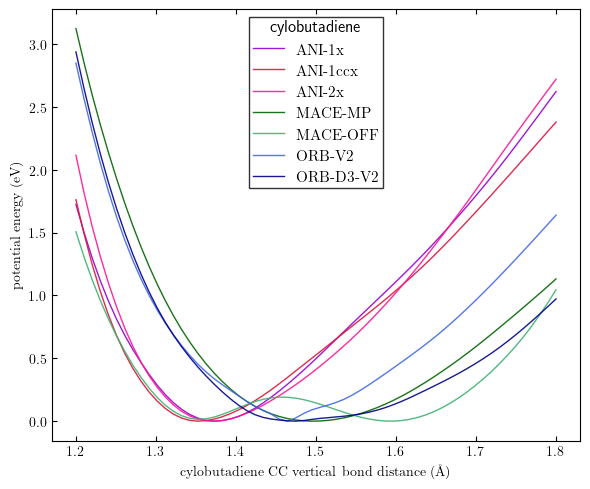

In [55]:
# deformació vertical
# define square
mol_name = 'cylobutadiene'
bond_name = 'CC'
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)
#view(molecule)

distances_v, energies_v = evaluate_bond(molecule, bond_ids_v, mask_v,  calculator_list, search_space=[1.2, 1.8], resolution=60, mol_name=mol_name, visualize=True)
plot_bond(distances_v, energies_v, calculator_names, calculator_colors, mol_name=mol_name, calc_name=CALC_NAME, bond_name=bond_name+' vertical')

computing C0-C1 PES
scan range [1.2, 1.8] Å
evaluating 60 distances
distances:
[1.2        1.21016949 1.22033898 1.23050847 1.24067797 1.25084746
 1.26101695 1.27118644 1.28135593 1.29152542 1.30169492 1.31186441
 1.3220339  1.33220339 1.34237288 1.35254237 1.36271186 1.37288136
 1.38305085 1.39322034 1.40338983 1.41355932 1.42372881 1.43389831
 1.4440678  1.45423729 1.46440678 1.47457627 1.48474576 1.49491525
 1.50508475 1.51525424 1.52542373 1.53559322 1.54576271 1.5559322
 1.56610169 1.57627119 1.58644068 1.59661017 1.60677966 1.61694915
 1.62711864 1.63728814 1.64745763 1.65762712 1.66779661 1.6779661
 1.68813559 1.69830508 1.70847458 1.71864407 1.72881356 1.73898305
 1.74915254 1.75932203 1.76949153 1.77966102 1.78983051 1.8       ]



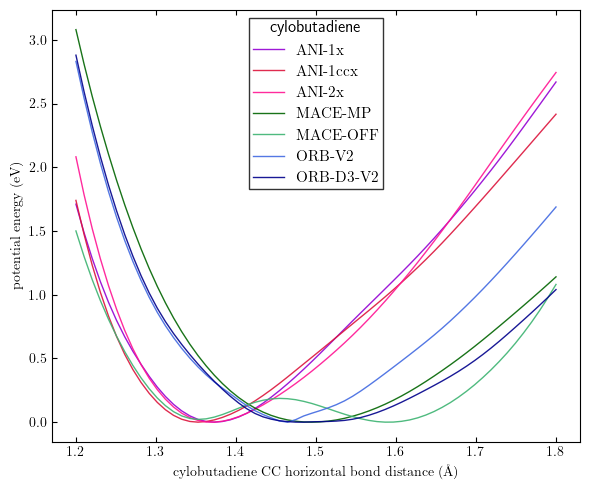

In [56]:
# deformació horitzontal
mol_name = 'cylobutadiene'
bond_name = 'CC'
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)
#view(molecule)

# deformació hortiztonal
distances_h, energies_h = evaluate_bond(molecule, bond_ids_h, mask_h,  calculator_list, search_space=[1.2, 1.8], resolution=60, mol_name=mol_name, visualize=True)
plot_bond(distances_h, energies_h, calculator_names, calculator_colors, mol_name=mol_name, calc_name=CALC_NAME, bond_name=bond_name+' horizontal')

In [57]:
# get the reference DFT structure 
ref_struct_path = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/scripts/gaussian/xyz_structures/cyclobutadiene_tight_DFT_wb97xd_6-31d.xyz'
ref_molecule = read(ref_struct_path)
vertical = ref_molecule.get_distance(0, 3)
horzontal = ref_molecule.get_distance(0, 1)
print(vertical, horzontal)
#view(ref_molecule)

1.3310960000634815 1.571132000135253


ORB-D3-V2

In [58]:
# calculator for this 2D PES scan
CALCULATOR = orb_calc_d3_v2
CALCULATOR_NAME = 'ORB-D3-v2'

energy_matrix = []

# initial square geometry
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)

work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

for d_x in distances_h:

    temp_list = []

    for d_y in distances_v:
        molecule.set_distance(bond_ids_h[0], bond_ids_h[1], d_x, fix=0, mask=mask_h)
        molecule.set_distance(bond_ids_v[0], bond_ids_v[1], d_y, fix=0, mask=mask_v)

        molecule.calc = CALCULATOR
        potential_e = molecule.get_potential_energy()
        temp_list.append(potential_e)

        traj.write(molecule)

    energy_matrix.append(temp_list)

In [59]:
corrected_energy_matrix = np.array(energy_matrix) - np.min(np.array(energy_matrix))

In [60]:
work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryReader(traj_path)
view(traj, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/2963044723.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/2963044723.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


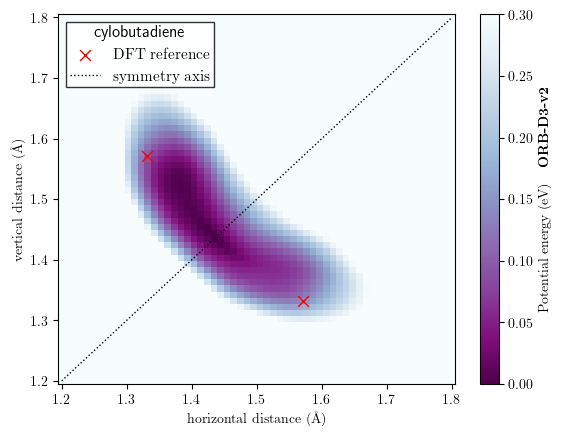

In [61]:
exes = [i for i in distances_h]


fig, ax = plt.subplots()
im = ax.pcolormesh(distances_h, distances_v, corrected_energy_matrix, vmax=0.3, cmap='BuPu_r', label=r'$\textnormal{}$')
ax.scatter(horzontal, vertical, color='red', marker='x', label=r'$\textnormal{DFT reference}$', s=60)
ax.scatter(vertical, horzontal, color='red', marker='x', s=60)
ax.plot(exes, exes, ls=':', color='black', label=r'$\textnormal{symmetry axis}$')
ax.set(xlabel=r'$\textnormal{horizontal distance (Å)}$', ylabel=r'$\textnormal{vertical distance (Å)}$')

ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
fig.colorbar(im, ax=ax, label=r'$\textnormal{Potential energy (eV)}\quad\textnormal{\textbf{'+f'{CALCULATOR_NAME}'+r'}}$')
fig.savefig(os.path.join(work_dir, f'{mol_name}_{CALCULATOR_NAME}'+'_2D_PES.png'), dpi=400)
fig.show()

Aquest és un exemple on el model prediu correctament les asimetries del sistema. Existeixen certes molècules on el trencament de la simetria pot ser beneficiós trencant certes degeneracions i estabilitzant el sistema. Second order Jean Teller effect. 

In [62]:
# calculator for this 2D PES scan
CALCULATOR = orb_calc_v2
CALCULATOR_NAME = 'ORB-v2'

energy_matrix = []

# initial square geometry
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)

work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

for d_x in distances_h:

    temp_list = []

    for d_y in distances_v:
        molecule.set_distance(bond_ids_h[0], bond_ids_h[1], d_x, fix=0, mask=mask_h)
        molecule.set_distance(bond_ids_v[0], bond_ids_v[1], d_y, fix=0, mask=mask_v)

        molecule.calc = CALCULATOR
        potential_e = molecule.get_potential_energy()
        temp_list.append(potential_e)

        traj.write(molecule)

    energy_matrix.append(temp_list)

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10

In [63]:
corrected_energy_matrix = np.array(energy_matrix) - np.min(np.array(energy_matrix))

In [64]:
work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryReader(traj_path)
view(traj, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/3739279841.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/3739279841.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


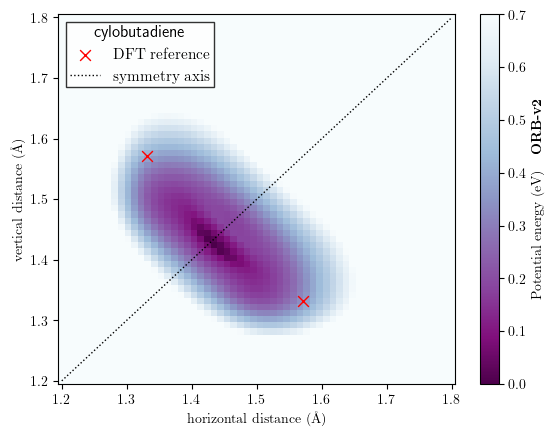

In [65]:
exes = [i for i in distances_h]


fig, ax = plt.subplots()
im = ax.pcolormesh(distances_h, distances_v, corrected_energy_matrix, vmax=0.7, cmap='BuPu_r', label=r'$\textnormal{}$')
ax.scatter(horzontal, vertical, color='red', marker='x', label=r'$\textnormal{DFT reference}$', s=60)
ax.scatter(vertical, horzontal, color='red', marker='x', s=60)
ax.plot(exes, exes, ls=':', color='black', label=r'$\textnormal{symmetry axis}$')
ax.set(xlabel=r'$\textnormal{horizontal distance (Å)}$', ylabel=r'$\textnormal{vertical distance (Å)}$')

ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
fig.colorbar(im, ax=ax, label=r'$\textnormal{Potential energy (eV)}\quad\textnormal{\textbf{'+f'{CALCULATOR_NAME}'+r'}}$')
fig.savefig(os.path.join(work_dir, f'{mol_name}_{CALCULATOR_NAME}'+'_2D_PES.png'), dpi=400)
fig.show()

MACE

In [66]:
# calculator for this 2D PES scan
CALCULATOR = maceoff
CALCULATOR_NAME = 'MACE-OFF'

energy_matrix = []

# initial square geometry
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)

work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

for d_x in distances_h:

    temp_list = []

    for d_y in distances_v:
        molecule.set_distance(bond_ids_h[0], bond_ids_h[1], d_x, fix=0, mask=mask_h)
        molecule.set_distance(bond_ids_v[0], bond_ids_v[1], d_y, fix=0, mask=mask_v)

        molecule.calc = CALCULATOR
        potential_e = molecule.get_potential_energy()
        temp_list.append(potential_e)

        traj.write(molecule)

    energy_matrix.append(temp_list)

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10

In [67]:
corrected_energy_matrix = np.array(energy_matrix) - np.min(np.array(energy_matrix))

In [68]:
work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryReader(traj_path)
view(traj, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/2440039475.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/2440039475.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


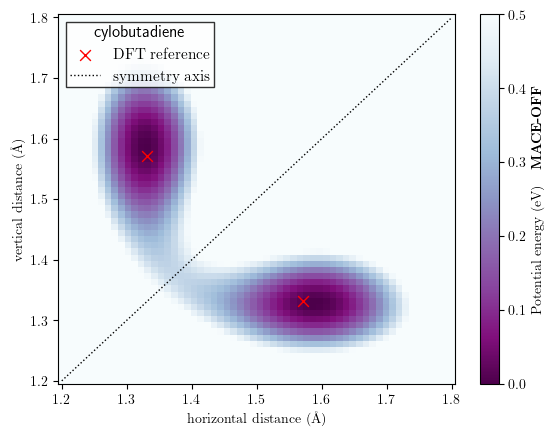

In [69]:
exes = [i for i in distances_h]


fig, ax = plt.subplots()
im = ax.pcolormesh(distances_h, distances_v, corrected_energy_matrix, vmax=0.5, cmap='BuPu_r', label=r'$\textnormal{}$')
ax.scatter(horzontal, vertical, color='red', marker='x', label=r'$\textnormal{DFT reference}$', s=60)
ax.scatter(vertical, horzontal, color='red', marker='x', s=60)
ax.plot(exes, exes, ls=':', color='black', label=r'$\textnormal{symmetry axis}$')
ax.set(xlabel=r'$\textnormal{horizontal distance (Å)}$', ylabel=r'$\textnormal{vertical distance (Å)}$')

ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
fig.colorbar(im, ax=ax, label=r'$\textnormal{Potential energy (eV)}\quad\textnormal{\textbf{'+f'{CALCULATOR_NAME}'+r'}}$')
fig.savefig(os.path.join(work_dir, f'{mol_name}_{CALCULATOR_NAME}'+'_2D_PES.png'), dpi=400)
fig.show()

In [70]:
# calculator for this 2D PES scan
CALCULATOR = macemp
CALCULATOR_NAME = 'MACE-MP'

energy_matrix = []

# initial square geometry
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)

work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

for d_x in distances_h:

    temp_list = []

    for d_y in distances_v:
        molecule.set_distance(bond_ids_h[0], bond_ids_h[1], d_x, fix=0, mask=mask_h)
        molecule.set_distance(bond_ids_v[0], bond_ids_v[1], d_y, fix=0, mask=mask_v)

        molecule.calc = CALCULATOR
        potential_e = molecule.get_potential_energy()
        temp_list.append(potential_e)

        traj.write(molecule)

    energy_matrix.append(temp_list)

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10

In [71]:
corrected_energy_matrix = np.array(energy_matrix) - np.min(np.array(energy_matrix))

In [72]:
work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryReader(traj_path)
view(traj, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/3739279841.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/3739279841.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


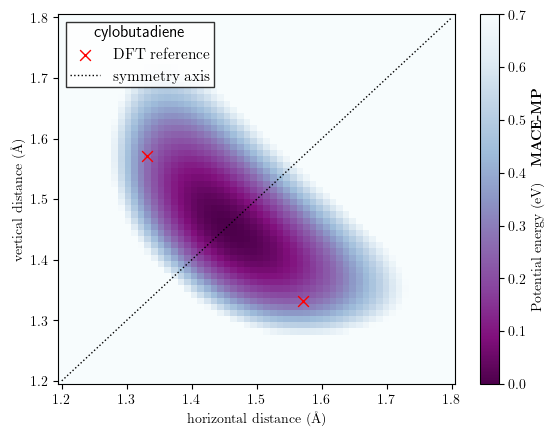

In [73]:
exes = [i for i in distances_h]


fig, ax = plt.subplots()
im = ax.pcolormesh(distances_h, distances_v, corrected_energy_matrix, vmax=0.7, cmap='BuPu_r', label=r'$\textnormal{}$')
ax.scatter(horzontal, vertical, color='red', marker='x', label=r'$\textnormal{DFT reference}$', s=60)
ax.scatter(vertical, horzontal, color='red', marker='x', s=60)
ax.plot(exes, exes, ls=':', color='black', label=r'$\textnormal{symmetry axis}$')
ax.set(xlabel=r'$\textnormal{horizontal distance (Å)}$', ylabel=r'$\textnormal{vertical distance (Å)}$')

ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
fig.colorbar(im, ax=ax, label=r'$\textnormal{Potential energy (eV)}\quad\textnormal{\textbf{'+f'{CALCULATOR_NAME}'+r'}}$')
fig.savefig(os.path.join(work_dir, f'{mol_name}_{CALCULATOR_NAME}'+'_2D_PES.png'), dpi=400)
fig.show()

In [74]:
# calculator for this 2D PES scan
CALCULATOR = ani1x_calc
CALCULATOR_NAME = 'ANI-1x'

energy_matrix = []

# initial square geometry
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)

work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

for d_x in distances_h:

    temp_list = []

    for d_y in distances_v:
        molecule.set_distance(bond_ids_h[0], bond_ids_h[1], d_x, fix=0, mask=mask_h)
        molecule.set_distance(bond_ids_v[0], bond_ids_v[1], d_y, fix=0, mask=mask_v)

        molecule.calc = CALCULATOR
        potential_e = molecule.get_potential_energy()
        temp_list.append(potential_e)

        traj.write(molecule)

    energy_matrix.append(temp_list)

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10

In [75]:
corrected_energy_matrix = np.array(energy_matrix) - np.min(np.array(energy_matrix))

In [76]:
work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryReader(traj_path)
view(traj, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/3739279841.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/3739279841.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


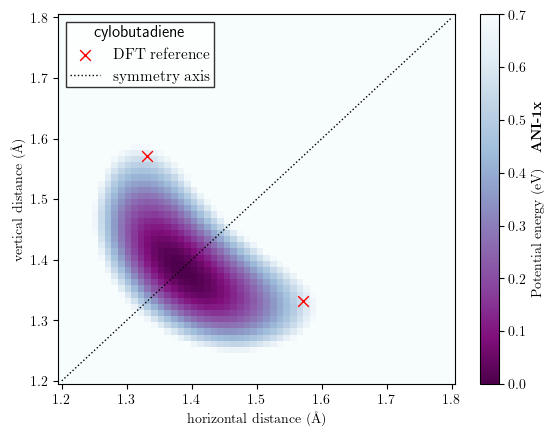

In [77]:
exes = [i for i in distances_h]


fig, ax = plt.subplots()
im = ax.pcolormesh(distances_h, distances_v, corrected_energy_matrix, vmax=0.7, cmap='BuPu_r', label=r'$\textnormal{}$')
ax.scatter(horzontal, vertical, color='red', marker='x', label=r'$\textnormal{DFT reference}$', s=60)
ax.scatter(vertical, horzontal, color='red', marker='x', s=60)
ax.plot(exes, exes, ls=':', color='black', label=r'$\textnormal{symmetry axis}$')
ax.set(xlabel=r'$\textnormal{horizontal distance (Å)}$', ylabel=r'$\textnormal{vertical distance (Å)}$')

ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
fig.colorbar(im, ax=ax, label=r'$\textnormal{Potential energy (eV)}\quad\textnormal{\textbf{'+f'{CALCULATOR_NAME}'+r'}}$')
fig.savefig(os.path.join(work_dir, f'{mol_name}_{CALCULATOR_NAME}'+'_2D_PES.png'), dpi=400)
fig.show()

In [78]:
# calculator for this 2D PES scan
CALCULATOR = ani2x_calc
CALCULATOR_NAME = 'ANI-2x'

energy_matrix = []

# initial square geometry
molecule = pubchem_atoms_search(smiles='C1=CC=C1')
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)

work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

for d_x in distances_h:

    temp_list = []

    for d_y in distances_v:
        molecule.set_distance(bond_ids_h[0], bond_ids_h[1], d_x, fix=0, mask=mask_h)
        molecule.set_distance(bond_ids_v[0], bond_ids_v[1], d_y, fix=0, mask=mask_v)

        molecule.calc = CALCULATOR
        potential_e = molecule.get_potential_energy()
        temp_list.append(potential_e)

        traj.write(molecule)

    energy_matrix.append(temp_list)

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10

In [79]:
corrected_energy_matrix = np.array(energy_matrix) - np.min(np.array(energy_matrix))

In [80]:
work_dir = os.path.join(os.curdir, 'PES_distances', mol_name)
traj_path = os.path.join(work_dir, 'bond_scan_2D.traj')
traj = trajectory.TrajectoryReader(traj_path)
view(traj, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/3739279841.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_83060/3739279841.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


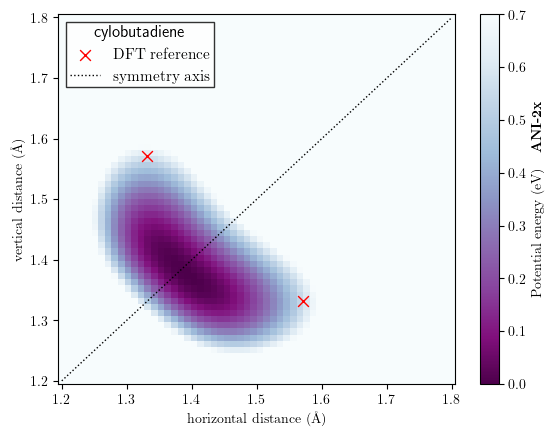

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10

In [81]:
exes = [i for i in distances_h]


fig, ax = plt.subplots()
im = ax.pcolormesh(distances_h, distances_v, corrected_energy_matrix, vmax=0.7, cmap='BuPu_r', label=r'$\textnormal{}$')
ax.scatter(horzontal, vertical, color='red', marker='x', label=r'$\textnormal{DFT reference}$', s=60)
ax.scatter(vertical, horzontal, color='red', marker='x', s=60)
ax.plot(exes, exes, ls=':', color='black', label=r'$\textnormal{symmetry axis}$')
ax.set(xlabel=r'$\textnormal{horizontal distance (Å)}$', ylabel=r'$\textnormal{vertical distance (Å)}$')

ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large')
fig.colorbar(im, ax=ax, label=r'$\textnormal{Potential energy (eV)}\quad\textnormal{\textbf{'+f'{CALCULATOR_NAME}'+r'}}$')
fig.savefig(os.path.join(work_dir, f'{mol_name}_{CALCULATOR_NAME}'+'_2D_PES.png'), dpi=400)
fig.show()